In [1]:
!pip install roboflow
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:0

In [2]:
import torch
import torchvision
import numpy as np
import json
import os
from roboflow import Roboflow
import matplotlib.pyplot as plt
import shutil
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader,DatasetMapper, build_detection_train_loader
import cv2
from detectron2.utils.events import EventStorage, CommonMetricPrinter, JSONWriter, TensorboardXWriter
from detectron2.modeling import build_model
from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog
import detectron2.utils.comm as comm
import datetime
import math
from math import nan
import time
from detectron2.checkpoint import DetectionCheckpointer

In [3]:
rf = Roboflow(api_key="DBMLp31pkUwD7UVq54eT")
project = rf.workspace("marketshelfdetection").project("oil-rvzxr")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to oil-1 in coco:: 100%|██████████| 58/58 [00:00<00:00, 3583.08it/s]


In [4]:
def load_coco_json(file_path):
    """Loads a COCO JSON file and returns a Python dictionary."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None

In [5]:
coco_data = load_coco_json('/content/oil-1/valid/_annotations.coco.json')

ids = []
labels = []
if coco_data:
    # You can now work with the 'coco_data' dictionary
    print(type(coco_data)) # Print the data type which should be a dictionary
    # For example, to access the first image's file name:
    categories = coco_data['categories']


    for category in categories:
      ids.append(category['id'])
      labels.append(category['name'])

    labels[0] = "background"
    obtained_dictionary = dict(zip(labels, ids))
    obtained_dictionary_2 = dict(zip(ids, labels))

    label_count = len(labels)

<class 'dict'>


In [6]:
DATA_DIR = '/content/oil-1'  # Replace with the actual path
os.makedirs(os.path.join(DATA_DIR, 'train_annotation'))
shutil.move(os.path.join(DATA_DIR, 'train/_annotations.coco.json'), os.path.join(DATA_DIR, 'train_annotation'))
TRAIN_ANNOTATION_FILE = os.path.join(DATA_DIR, 'train_annotation/_annotations.coco.json')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'train')  # Adjust as needed
os.makedirs(os.path.join(DATA_DIR, 'val_annotation'))
shutil.move(os.path.join(DATA_DIR, 'valid/_annotations.coco.json'), os.path.join(DATA_DIR, 'val_annotation'))
VAL_ANNOTATION_FILE = os.path.join(DATA_DIR, 'val_annotation/_annotations.coco.json')
VAL_IMAGE_DIR = os.path.join(DATA_DIR, 'valid')    # Adjust as needed
os.makedirs(os.path.join(DATA_DIR, 'test_annotation'))
shutil.move(os.path.join(DATA_DIR, 'test/_annotations.coco.json'), os.path.join(DATA_DIR, 'test_annotation'))
TEST_ANNOTATION_FILE = os.path.join(DATA_DIR, 'test_annotation/_annotations.coco.json')
TEST_IMAGE_DIR = os.path.join(DATA_DIR, 'test')
NUM_CLASSES = label_count  # Replace with the number of classes in your dataset (e.g., 80 for COCO)
BATCH_SIZE = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

In [7]:
register_coco_instances("my_dataset_train", {}, TRAIN_ANNOTATION_FILE, TRAIN_IMAGE_DIR)
register_coco_instances("my_dataset_val", {}, VAL_ANNOTATION_FILE, VAL_IMAGE_DIR)

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # pretrained weights
cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.SOLVER.BASE_LR = LEARNING_RATE
cfg.SOLVER.MAX_ITER = 3000  # 40*300/4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  # e.g., 3
#cfg.SOLVER.LOGGING_PERIOD = 10
#cfg.SOLVER.CHECKPOINT_PERIOD = 10
#cfg.TEST.EVAL_PERIOD = 10
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [9]:
class LossHook(HookBase):
    def __init__(self, cfg, is_validation=False):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = self.cfg.DATASETS.TEST if is_validation else self.cfg.DATASETS.TRAIN
        self._loader = iter(build_detection_train_loader(self.cfg))
        self.loss_prefix = "val_" if is_validation else "train_"
        self.total_images = 40
        self.total_loss = 0
        self.total_batches=0
        self.patience=5
        self.no_improvements = 0
        self.best_val_loss = float('inf')
        self.is_validation = is_validation
        self.prev_epoch = 0
        self.prev_loss = 0
        self.iter_count = 0
        self.iters_per_epoch = self.total_images // self.cfg.SOLVER.IMS_PER_BATCH
        self.warmup_epoch = self.cfg.SOLVER.WARMUP_ITERS/self.iters_per_epoch

    def after_step(self):
        if self.trainer.iter <= self.cfg.SOLVER.WARMUP_ITERS:
            return
        else:
            data = next(self._loader)
            with torch.no_grad():
                loss_dict = self.trainer.model(data)
                losses = sum(loss_dict.values())
                assert torch.isfinite(losses).all(), loss_dict
                loss_dict_reduced = {self.loss_prefix + k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                self.total_loss += losses_reduced
                self.total_batches += 1
                self.iter_count += 1

            if self.total_batches>0 and comm.is_main_process() and self.iter_count==self.iters_per_epoch:
                epoch = math.ceil(self.trainer.iter / self.iters_per_epoch)
                average_loss = self.total_loss / self.total_batches

                if self.prev_epoch!= epoch:
                  self.prev_epoch = epoch
                  self.prev_loss = average_loss
                  print(f"{self.loss_prefix.capitalize()}Loss (Epoch {int(self.prev_epoch - self.warmup_epoch)}): {self.prev_loss:.4f}")

                if self.is_validation:
                    if average_loss < self.best_val_loss:
                        self.best_val_loss = average_loss
                        self.no_improvements = 0
                    else:
                        self.no_improvements += 1

                    if self.no_improvements >= self.patience:
                        checkpointer = DetectionCheckpointer(self.trainer.model, save_dir=self.cfg.OUTPUT_DIR)
                        checkpointer.save("FasterRCNN_Oil")
                        raise StopIteration("Early Stopping Trigerred")

                self.total_loss = 0
                self.total_batches=0
                self.iter_count=0
            else:
                return

In [10]:
trainer = DefaultTrainer(cfg)
#train_loss_hook = LossHook(cfg, is_validation=False)
val_loss_hook = LossHook(cfg, is_validation=True)
trainer.register_hooks([val_loss_hook])
trainer.resume_or_load(resume=False)
trainer.train()

[05/28 05:14:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 137MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/28 05:14:16 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


[05/28 05:14:24 d2.utils.events]:  eta: 0:13:00  iter: 19  total_loss: 4.515  loss_cls: 3.418  loss_box_reg: 0.8052  loss_rpn_cls: 0.172  loss_rpn_loc: 0.122    time: 0.2699  last_time: 0.2647  data_time: 0.1098  last_data_time: 0.1076   lr: 1.9981e-05  max_mem: 3847M
[05/28 05:14:34 d2.utils.events]:  eta: 0:12:37  iter: 39  total_loss: 4.041  loss_cls: 3.023  loss_box_reg: 0.8469  loss_rpn_cls: 0.1039  loss_rpn_loc: 0.1123    time: 0.2620  last_time: 0.2676  data_time: 0.1020  last_data_time: 0.1129   lr: 3.9961e-05  max_mem: 3848M
[05/28 05:14:39 d2.utils.events]:  eta: 0:12:30  iter: 59  total_loss: 2.748  loss_cls: 1.759  loss_box_reg: 0.8364  loss_rpn_cls: 0.06333  loss_rpn_loc: 0.09372    time: 0.2585  last_time: 0.2385  data_time: 0.0998  last_data_time: 0.0955   lr: 5.9941e-05  max_mem: 3854M
[05/28 05:14:44 d2.utils.events]:  eta: 0:12:22  iter: 79  total_loss: 2.392  loss_cls: 1.394  loss_box_reg: 0.8557  loss_rpn_cls: 0.04852  loss_rpn_loc: 0.09381    time: 0.2565  last_tim

StopIteration: Early Stopping Trigerred

Using Model Immediately (No Autostop)

In [ ]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
results=inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
print(results)

In [ ]:
images = os.listdir(TEST_IMAGE_DIR)
for imageName in images:
  image = cv2.imread(os.path.join(TEST_IMAGE_DIR, imageName))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  height, width = image.shape[:2]
  inputs = [{"image": torch.as_tensor(image.transpose(2, 0, 1)).float().to("cuda"), "height": height, "width": width}]

# Run inference
  trainer.model.eval()
  with torch.no_grad():
      outputs = trainer.model(inputs)[0]  # returns list of outputs

# Access outputs
  instances = outputs["instances"].to("cpu")
  plt.figure(figsize=(12, 8))
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
  out = v.draw_instance_predictions(instances)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.axis("off")
  plt.show()

Using Checkpoint after Autostop

In [11]:
model = build_model(cfg)
DetectionCheckpointer(model).load('/content/output/FasterRCNN_Oil.pth')

[05/28 05:19:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/FasterRCNN_Oil.pth ...


{}

In [12]:
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
results=inference_on_dataset(model, val_loader, evaluator)

WARNING [05/28 05:19:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/28 05:19:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/28 05:19:55 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/oil-1/val_annotation/_annotations.coco.json
[05/28 05:19:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/28 05:19:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/28 05:19:55 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[05/28 05:19:55 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/28 05:19:55 d2.evaluation.evaluator]: Start inference on 5 batches
[05/28 05:19:55 d2.evalua

In [13]:
print(results)

OrderedDict([('bbox', {'AP': 51.47881835392909, 'AP50': 71.1491256268484, 'AP75': 63.05115511551155, 'APs': nan, 'APm': 57.955010336198455, 'APl': 55.67536008848234, 'AP-products-dut2': nan, 'AP-alfamart_oil': 70.0, 'AP-alfamart_premium_rice': nan, 'AP-alfamart_rice': nan, 'AP-alfamart_rice_pandan_wangi': 0.0, 'AP-alfamart_rice_setrapulen': 34.772277227722775, 'AP-alfamart_rice_setraramos': 51.02310231023102, 'AP-alfamidi_oil': nan, 'AP-bamco_coconut_oil': 59.471947194719476, 'AP-bimoli_canister': 80.0990099009901, 'AP-bimoli_oil': 66.62963944890731, 'AP-bimoli_spesial': 48.996699669967, 'AP-camar_oil': 57.57425742574257, 'AP-filma_oil': 55.71782178217822, 'AP-food_station_rice': nan, 'AP-fortune_oil': 76.63366336633663, 'AP-happy_soya_oil': nan, 'AP-harumas_oil': 62.244224422442244, 'AP-ikan_dorang_coconut_oil': 80.0, 'AP-indomaret_oil': nan, 'AP-indomaret_ramos_rice': nan, 'AP-indomaret_red_rice': nan, 'AP-kunci_mas_oil': nan, 'AP-raja_platinum_rice': 74.45544554455445, 'AP-raja_ulti

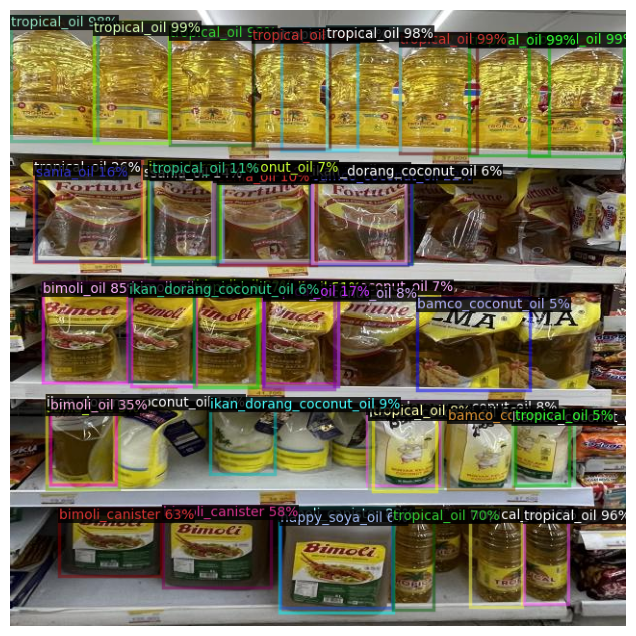

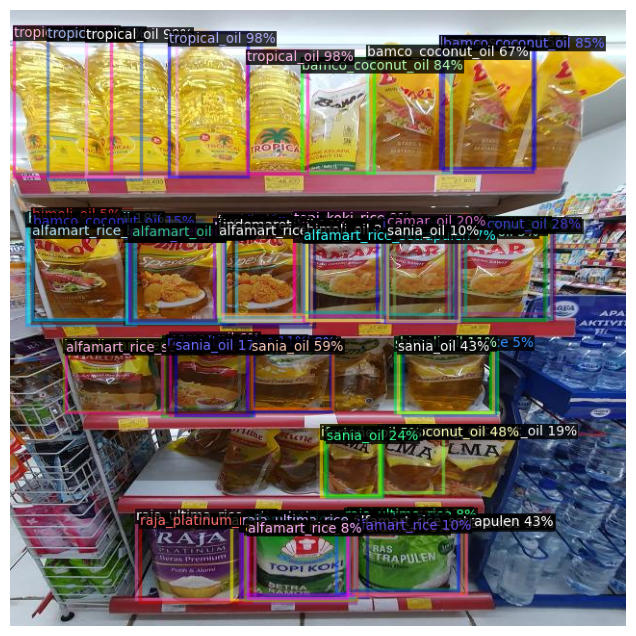

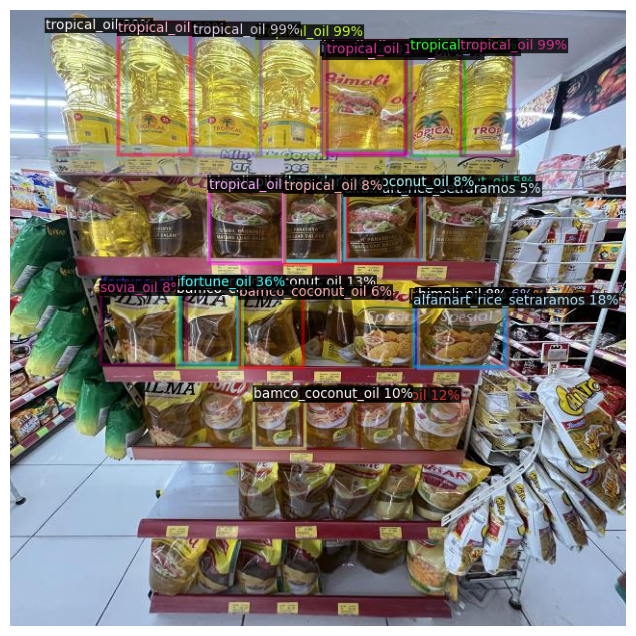

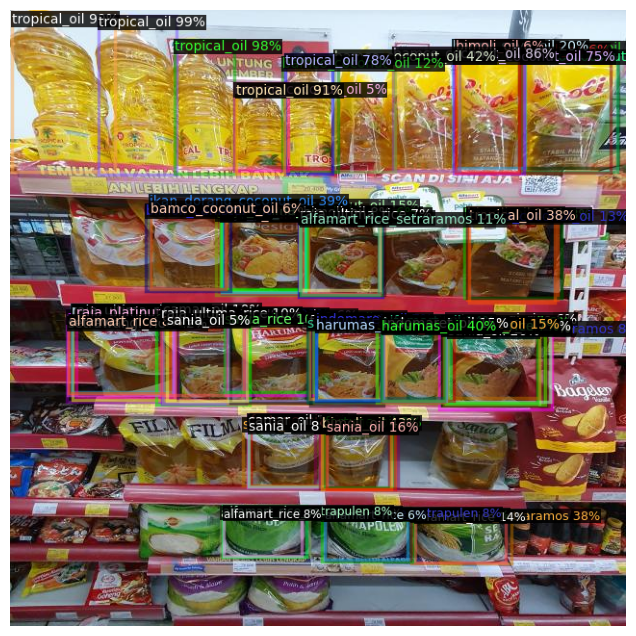

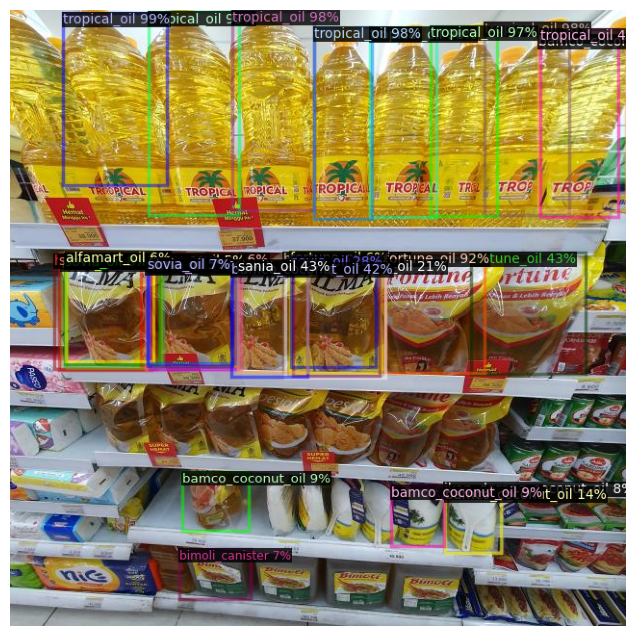

In [14]:
images = os.listdir(TEST_IMAGE_DIR)
for imageName in images:
  image = cv2.imread(os.path.join(TEST_IMAGE_DIR, imageName))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  height, width = image.shape[:2]
  inputs = [{"image": torch.as_tensor(image.transpose(2, 0, 1)).float().to("cuda"), "height": height, "width": width}]

# Run inference
  model.eval()
  with torch.no_grad():
      outputs = model(inputs)[0]  # returns list of outputs

# Access outputs
  instances = outputs["instances"].to("cpu")
  plt.figure(figsize=(12, 8))
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
  out = v.draw_instance_predictions(instances)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.axis("off")
  plt.show()